In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

import cv2

print(torch.__version__, torchvision.__version__)

/mnt/beegfs/home/ypang2022/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu116 0.14.1+cu116


In [2]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# tp = transforms.Compose([
#     transforms.Resize(32),
#     transforms.CenterCrop(32),
#     transforms.ToTensor()
# ])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# def label_to_onehot(target, num_classes=100):
#     target = torch.unsqueeze(target, 1)
#     onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
#     onehot_target.scatter_(1, target, 1)
#     return onehot_target

# def cross_entropy_for_onehot(pred, target):
#     return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cuda


In [3]:
# from config import cfg
import torch
import torch.nn as nn
import torch.nn.functional as F
# from misc.layer import Conv2d, FC
from torchvision import models
# from misc.utils import *

# model_path = '../PyTorch_Pretrained/vgg16-397923af.pth'

# from config import cfg
import torch
import torch.nn as nn
import torch.nn.functional as F
# from misc.layer import Conv2d, FC
from torchvision import models
# from misc.utils import *

# model_path = '../PyTorch_Pretrained/vgg16-397923af.pth'

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, NL='relu', same_padding=False, bn=False,
                 dilation=1, groups=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation == 1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation,
                                  groups=groups, bias=not bn)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation,
                                  groups=groups, bias=not bn)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        if NL == 'relu':
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class FC(nn.Module):
    def __init__(self, in_features, out_features, NL='relu'):
        super(FC, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        if NL == 'relu':
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
        x = self.fc(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class VGG_decoder(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG_decoder, self).__init__()
        
        self.de_pred = nn.Sequential(Conv2d( 512, 128, 3, same_padding=True, NL='relu'),
                                    nn.ConvTranspose2d(128,64,4,stride=2,padding=1,output_padding=0,bias=True),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(64,32,4,stride=2,padding=1,output_padding=0,bias=True),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(32,16,4,stride=2,padding=1,output_padding=0,bias=True),
                                    nn.ReLU(),
                                    Conv2d(16, 1, 1, same_padding=True, NL='relu'))
        
        self._initialize_weights()
        vgg = models.vgg16(pretrained=pretrained)
        # if pretrained:
        #     vgg.load_state_dict(torch.load(model_path))
        features = list(vgg.features.children())
        self.features4 = nn.Sequential(*features[0:23])


    def forward(self, x):
        x = self.features4(x)       
        x = self.de_pred(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [4]:
net = VGG_decoder().to(device)
    
net.load_state_dict(torch.load(r'images/VGGDe_FedAvg_IID_mae_4.081_mse_10.808_ep_36.pth.tar')['state_dict'])

/mnt/beegfs/home/ypang2022/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/mnt/beegfs/home/ypang2022/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [5]:
# net._initialize_weights()
criterion = nn.MSELoss().cuda()

In [6]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.5, 0.5)
    
# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         act = nn.Sigmoid
#         self.body = nn.Sequential(
#             nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(768, 100)
#         )
        
#     def forward(self, x):
#         out = self.body(x)
#         out = out.view(out.size(0), -1)
#         # print(out.size())
#         out = self.fc(out)
#         return out
    
# net = LeNet().to(device)
    
# net.apply(weights_init)
# criterion = cross_entropy_for_onehot

In [7]:
# ######### honest partipant #########
# img_index = 25
# gt_data = tp(dst[img_index][0]).to(device)
# gt_data = gt_data.view(1, *gt_data.size())
# gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
# gt_label = gt_label.view(1, )
# gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# plt.imshow(tt(gt_data[0].cpu()))
# plt.title("Ground truth image")
# print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# # compute original gradient 
# out = net(gt_data)
# y = criterion(out, gt_onehot_label)
# dy_dx = torch.autograd.grad(y, net.parameters())


# # share the gradients with other clients
# original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [8]:
# img = r'images/a3ee7e9d13c3c256d4f3f4620b5b7ed4.jpg'

In [9]:
import h5py

# 打开HDF5文件，并读取名为"data"的数据集
with h5py.File("images/a3ee7e9d13c3c256d4f3f4620b5b7ed4.h5", "r") as f:
    tensor_np = f["density_map"][()]

# 将Numpy数组转换为PyTorch张量
gt_map = torch.from_numpy(tensor_np).cuda()

In [10]:
img_ = Image.open(r'images/a3ee7e9d13c3c256d4f3f4620b5b7ed4.jpg').convert("RGB")
# img_ = cv2.imread(r'images/a3ee7e9d13c3c256d4f3f4620b5b7ed4.jpg')
# img_tensor = torch.Tensor(img_).permute(2, 0, 1).unsqueeze(0).cuda()
# dot = torch.Trans
# gs_np = gs(dot)[0].cpu().numpy()
# plt.imshow(img)

In [11]:
MEAN_STD = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
trans=transforms.Compose([
                        transforms.ToTensor(), transforms.Normalize(mean=MEAN_STD[0],
                                                                    std=MEAN_STD[1]),
                    ])

In [12]:
img_tensor = trans(img_).cuda()

In [13]:
img_tensor

tensor([[[ 0.5536,  0.5536,  0.5536,  ...,  0.7077,  0.9817,  1.5125],
         [ 0.5536,  0.5536,  0.5536,  ...,  0.4508,  0.2111,  0.4679],
         [ 0.5536,  0.5536,  0.5364,  ..., -0.5767, -1.1589, -1.0562],
         ...,
         [ 0.2624,  0.2624,  0.2453,  ..., -1.8953, -1.5699, -1.5014],
         [ 0.2453,  0.2453,  0.2453,  ..., -1.8439, -2.1179, -2.1179],
         [ 0.2111,  0.2282,  0.2453,  ..., -1.6384, -1.8097, -1.8439]],

        [[ 0.6078,  0.6078,  0.6078,  ...,  0.8529,  1.0630,  1.6057],
         [ 0.6078,  0.6078,  0.6078,  ...,  0.5203,  0.2402,  0.4503],
         [ 0.6078,  0.6078,  0.5903,  ..., -0.6352, -1.3179, -1.2304],
         ...,
         [ 0.3803,  0.3803,  0.3627,  ..., -1.5280, -1.2479, -1.1253],
         [ 0.3627,  0.3627,  0.3627,  ..., -1.5280, -1.8782, -1.9482],
         [ 0.3277,  0.3452,  0.3627,  ..., -1.3529, -1.5280, -1.5630]],

        [[ 0.3045,  0.3045,  0.3045,  ...,  1.0714,  1.2631,  1.8034],
         [ 0.3045,  0.3045,  0.3045,  ...,  0

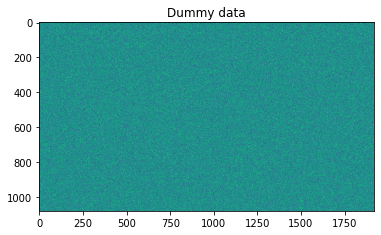

Text(0.5, 1.0, 'Dummy label')

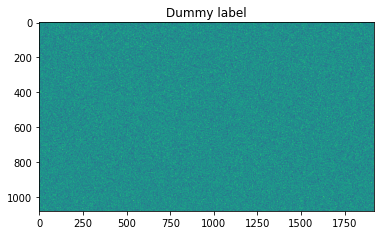

In [14]:
# generate dummy data and label
dummy_data = torch.randn(img_tensor.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_map.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
plt.show()
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy label")

In [15]:
######### honest partipant #########
# img_index = 25
# gt_data = tp(dst[img_index][0]).to(device)
# gt_data = gt_data.view(1, *gt_data.size())
# gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
# gt_label = gt_label.view(1, )
# gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# plt.imshow(tt(gt_data[0].cpu()))
# plt.title("Ground truth image")
# print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient 
out = net(img_tensor)
y = criterion(out, gt_map.squeeze())
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

/mnt/beegfs/home/ypang2022/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1080, 1920])) that is different to the input size (torch.Size([1, 1080, 1920])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
torch.sum(out)/1000

tensor(324.6921, device='cuda:0', grad_fn=<DivBackward0>)

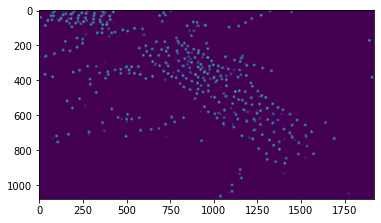

In [17]:
plt.imshow(out.cpu().detach().numpy()[0])

In [18]:
# pred = net(dummy_data)

In [19]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
#         dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 122.0173
10 122.0173
20 122.0173
30 122.0173
40 122.0173
50 122.0173
60 122.0173
70 122.0173
80 122.0173
90 122.0173
100 122.0173
110 122.0173
120 122.0173
130 122.0173
140 122.0173
150 122.0173
160 122.0173
170 122.0173
180 122.0173
190 122.0173
200 122.0173
210 122.0173
220 122.0173
230 122.0173
240 122.0173
250 122.0173
260 122.0173
270 122.0173
280 122.0173
290 122.0173


ValueError: only one element tensors can be converted to Python scalars

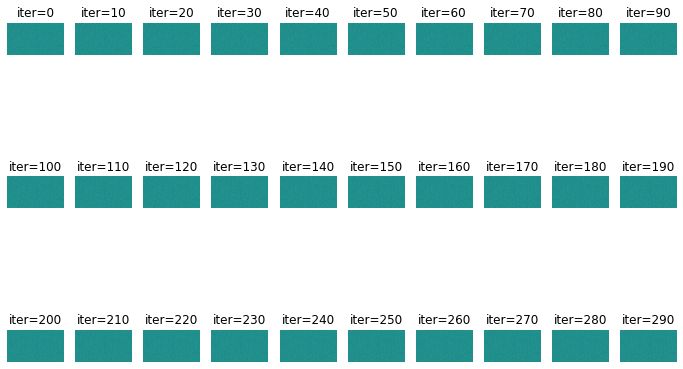

In [20]:
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i * 10])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

1. 优化问题

在小尺寸分类任务中，输入图像的维度相对较低，这使得优化问题更容易处理。相比之下，人群计数任务涉及高分辨率的输入图像和密度图，使得优化问题的维度显著增加。从优化的角度来看，随着问题维度的增加，局部最优解和鞍点的数量也会增加，这将使得寻找全局最优解变得更加困难。因此，在高维度情况下，DLG攻击可能难以找到能有效恢复数据的最优解，从而降低攻击效果。此外，DLG攻击的目标是最小化虚拟梯度与真实梯度之间的差异。在小尺寸分类任务中，这种方法可能足够有效地恢复数据，因为输入数据和标签数据之间的相关性较强。然而，在人群计数任务中，由于攻击者需要同时恢复输入图像和密度图，优化目标可能无法准确捕捉到它们之间的所有相关性，导致攻击效果受到限制。

2. 模型容量

在小尺寸分类任务中，使用的模型（如LeNet等）通常具有足够的容量来表达输入数据的所有信息。这意味着攻击者可以通过调整模型参数以最小化梯度差异来有效地恢复训练数据。然而，在人群计数任务中，模型需要处理高分辨率的输入图像和密度图，可能无法完全表达这些数据的所有信息。模型容量的限制可能导致攻击者无法完全恢复输入数据和标签数据的所有细节，从而降低攻击效果。


3. 损失函数和梯度计算

在小尺寸分类任务中，损失函数和梯度计算相对简单，这使得攻击者可以利用梯度信息来还原训练数据。然而，在人群计数任务中，损失函数和梯度计算可能更为复杂，这会增加攻击者还原数据的难度。例如，人群计数任务中的损失函数可能涉及到像素级别的差异，这会导致梯度信息在空间上呈现出复杂的模式。在这种情况下，攻击者需要在高维度空间中解决一个复杂的优化问题，这可能导致攻击效果下降。

4. 总结

综上所述，DLG攻击在小尺寸分类任务中可能有效，因为优化问题相对简单，模型容量足够表达数据信息，优化目标能够有效地捕捉到数据之间的相关性，以及损失函数和梯度计算的简单性。然而，在人群计数任务中，由于问题维度较高、模型容量限制、优化目标的复杂性和损失函数及梯度计算的复杂性，DLG攻击可能无法完全恢复输入图像和密度图。

这并不意味着人群计数任务完全安全，而是表明DLG攻击在这种情况下可能效果有限。针对人群计数任务，可能需要设计更加专门的攻击策略。例如，攻击者可以尝试利用其他信息（如输入图像和密度图之间的先验关系）来辅助攻击，或者针对具体的人群计数模型设计特定的攻击方法。此外，研究者可以考虑探讨其他潜在的攻击方法，如基于模型生成的对抗样本或利用模型的中间表示来泄露训练数据信息。总之，对于人群计数任务，确保数据隐私和模型安全仍然是一个重要的研究方向。